In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

#from google.colab import drive
#drive.mount('/content/drive')

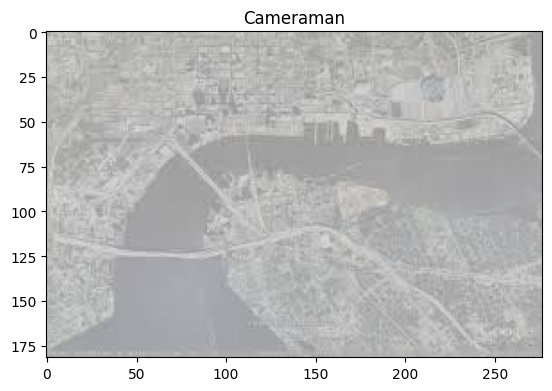

In [7]:
#I = io.imread("/content/drive/My Drive/MM803_2020/Week02/cameraman.png")
I = io.imread("test.jpg")

%matplotlib inline
fig=plt.figure()
plt.imshow(I, cmap='gray')
plt.title("Cameraman")
plt.show()

## Let's compute histogram of the cameraman image

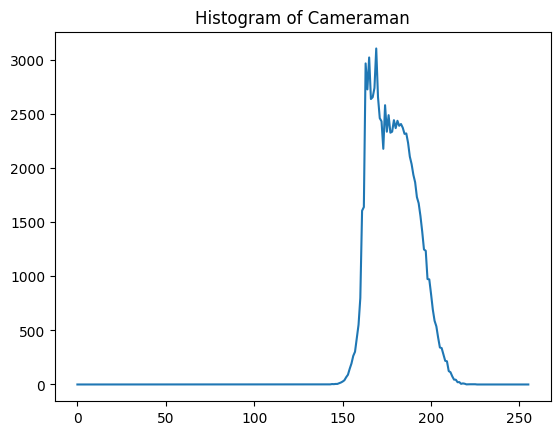

In [11]:
h,w, l = I.shape
hist = np.zeros(256)
for i in np.arange(0,h,1):
  for j in np.arange(0,w,1):
    hist[I[i,j]] += 1

%matplotlib inline
fig=plt.figure()
plt.plot(hist)
plt.title("Histogram of Cameraman")
plt.show()

## Let's compute cumulative histogram

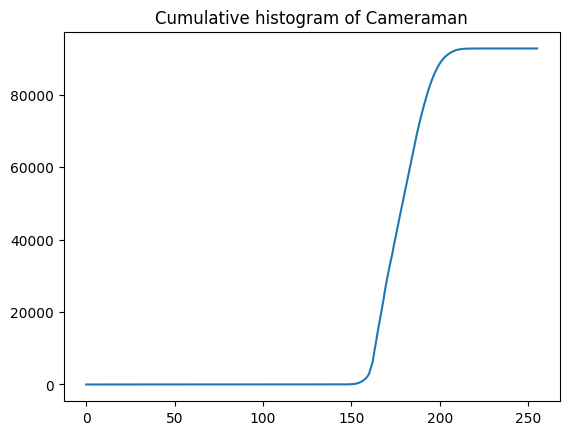

In [18]:
# cumulative histogram computation
H = np.zeros(256)
H[0] = hist[0]
for n in np.arange(1,256,1):
  H[n] = H[n-1] + hist[n]

%matplotlib inline
fig=plt.figure()
plt.plot(H)
plt.title("Cumulative histogram of Cameraman")
plt.show()

Let's now try to apply histogram equalization

$a^{\prime} = \left \lfloor{\frac{K-1}{MN}H(a)+0.5}\right \rfloor  $

In [ ]:
J = np.zeros((h,w))
for i in np.arange(0,h,1):
  for j in np.arange(0,w,1):
    J[i,j] = np.floor((255.0/(h*w))*H[I[i,j]]+0.5)

%matplotlib inline
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(I, cmap='gray')
plt.title("Cameraman image")

plt.subplot(1,2,2)
plt.imshow(J, cmap='gray')
plt.title("Cameraman after histogram equalization")
plt.show()

## Let's now try histogram shaping.

Let's assume that our reference histogram is Gaussian shaped

In [ ]:
from scipy import stats

# Reference histogram - Gaussian shaped
bins = np.linspace(-3, 3, 257)
bin_centers = 0.5*(bins[1:] + bins[:-1]) # we need 256 bin centers
refhist = stats.norm.pdf(bin_centers) # so that the length of refhist is 256
# cumulative reference histogram
refH = np.cumsum(refhist)
refH = refH/refH[255] # normalize cumulative histogram

%matplotlib inline
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(refhist)
plt.title("Refernce histogram")

plt.subplot(1,2,2)
plt.plot(refH)
plt.title("Cumulative refernce histogram (normalized)")
plt.show()

## Now let's compute histogram shaping with the reference histogram
$a^{\prime} = P_R^{-1}(P_A(a))$

In [ ]:
K = np.zeros((h,w))
for i in np.arange(0,h,1):
  for j in np.arange(0,w,1):
    pa = H[I[i,j]]/(h*w) # = P_A why did we divide H by (h*w) here?
    K[i,j] = np.searchsorted(refH,pa) # what does searchsorted function do?

%matplotlib inline
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(I, cmap='gray')
plt.title("Cameraman image")

plt.subplot(1,2,2)
plt.imshow(K, cmap='gray')
plt.title("Cameraman after histogram shaping")
plt.show()

Let's plot 
$a^{\prime} = P_R^{-1}(P_A(a))$
to visualize it!

What can we say about the nature of this function?

In [ ]:
a = np.arange(0,256,1)
ap= np.zeros([256])
for i in range(256):
    pa = H[i]/(h*w)
    ap[i] = np.searchsorted(refH,pa)

%matplotlib inline
fig=plt.figure()
plt.plot(ap,a)
plt.title("Transfer function")
plt.xlabel("input intensity value")
plt.ylabel("output intensity value")
plt.show()

# Local Histogram Equalization (also known as Adaptive Histogram Equalization)

## https://en.wikipedia.org/wiki/Adaptive_histogram_equalization

## https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_local_equalize.html

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = img_as_ubyte(data.moon())

# Global equalize
img_rescale = exposure.equalize_hist(img)

# Equalization
selem = disk(30)
img_eq = rank.equalize(img, selem=selem)


# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()